## Carga de datos

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import gzip
from io import BytesIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import time
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

GITHUB_RAW_URL = "https://raw.githubusercontent.com/Yael-Parra/Airbnb-Analysis/dev/data/airbnb_cleaned.csv.gz"

def load_airbnb_data_from_github(url):
    print("🔗 Descargando datos desde GitHub...")
    try:
        response = requests.get(url)
        response.raise_for_status()
        with gzip.open(BytesIO(response.content), 'rt', encoding='utf-8') as f:
            df = pd.read_csv(f)
        print(f"🔗 Datos cargados exitosamente ({df.shape[0]:,} filas, {df.shape[1]} columnas)")
        return df
    except Exception as e:
        print(f"❌ Error al cargar datos: {e}")
        return None

df = load_airbnb_data_from_github(GITHUB_RAW_URL)

🔗 Descargando datos desde GitHub...
🔗 Datos cargados exitosamente (220,031 filas, 17 columnas)


## Función del análisis PCA

In [58]:
def pca_analysis(df, feature_columns, n_components=5):
    print("📊 Realizando PCA...")
    start_time = time.time()

    X = df[feature_columns].fillna(df[feature_columns].median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    elapsed = time.time() - start_time
    print(f"✅ PCA completado en {elapsed:.2f}s")

    for i, var in enumerate(pca.explained_variance_ratio_):
        print(f"   PC{i+1}: {var:.3f} ({var*100:.1f}%)")

    return pca, scaler, X_pca, X_scaled


## Extracción de las variables más influyentes por componente

In [59]:
def extract_key_features(pca_model, feature_names, n_components=2):
    print("🔍 Extrayendo variables clave por componente...")
    key_features = {}

    for i in range(n_components):
        loadings = pca_model.components_[i]
        top_indices = np.argsort(np.abs(loadings))[-3:][::-1]
        print(f" PC{i+1}:")
        for j in top_indices:
            print(f"   - {feature_names[j]}: {loadings[j]:.3f}")
        key_features[f"PC{i+1}"] = [(feature_names[j], loadings[j]) for j in top_indices]

    return key_features


## Búsqueda optimizada del número de clusters

Se usa MiniBatchKMeans para mejor rendimiento y silhouette_score solo sobre una muestra de datos para reducir el coste computacional.

In [60]:
def find_optimal_clusters(pca_data, max_k=8, sample_size=2000):
    print("🔎 Buscando número óptimo de clusters...")
    start_time = time.time()

    k_range = range(2, max_k + 1)
    silhouette_scores = []
    inertias = []

    sample = pca_data[np.random.choice(pca_data.shape[0], size=sample_size, replace=False)]

    for k in k_range:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
        labels = kmeans.fit_predict(sample)
        silhouette = silhouette_score(sample, labels)
        silhouette_scores.append(silhouette)
        inertias.append(kmeans.inertia_)
        print(f"   k={k} → silhouette={silhouette:.3f}, inertia={kmeans.inertia_:.0f}")

    best_k = k_range[np.argmax(silhouette_scores)]
    print(f"✅ Mejor k: {best_k} con Silhouette={max(silhouette_scores):.3f}")
    print(f"⌛ Evaluación completada en {time.time() - start_time:.2f}s")
    return best_k, silhouette_scores, inertias


## Clustering final y análisis de distribución

In [61]:
def clustering_analysis(pca_data, n_clusters):
    print(f"📌 Aplicando MiniBatchKMeans con k={n_clusters}...")
    start = time.time()

    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1024)
    clusters = kmeans.fit_predict(pca_data)
    silhouette = silhouette_score(pca_data, clusters)

    print(f"✅ Clustering en {time.time() - start:.2f}s. Silhouette: {silhouette:.3f}")
    for cluster_id in np.unique(clusters):
        count = np.sum(clusters == cluster_id)
        print(f"   Cluster {cluster_id}: {count} muestras ({count/len(clusters)*100:.1f}%)")
    return clusters, kmeans


## Visualización de clusters en el espacio PCA

In [62]:
def visualize_clusters_simple(pca_data, clusters, kmeans_model):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='tab10', alpha=0.6, s=10)
    plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1],
                c='black', marker='x', s=200, label='Centroides')
    plt.title("Distribución de Clusters en Espacio PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.colorbar(scatter)
    plt.show()


## Análisis de características por cluster

In [63]:
def analyze_cluster_characteristics(df, clusters, feature_columns):
    df_temp = df[feature_columns].copy()
    df_temp["Cluster"] = clusters

    cluster_means = df_temp.groupby("Cluster").mean()
    global_means = df_temp[feature_columns].mean()

    print("📊 Características destacadas por cluster (vs. media global):")
    for cluster_id in cluster_means.index:
        diffs = ((cluster_means.loc[cluster_id] - global_means) / global_means * 100).sort_values(key=abs, ascending=False)
        print(f"\nCluster {cluster_id}:")
        for feature in diffs.head(3).index:
            sign = "↑" if diffs[feature] > 0 else "↓"
            print(f"   {sign} {feature}: {diffs[feature]:+.1f}%")


## Ejecución del análisis completo

📊 Realizando PCA...
✅ PCA completado en 0.07s
   PC1: 0.278 (27.8%)
   PC2: 0.188 (18.8%)
   PC3: 0.170 (17.0%)
   PC4: 0.154 (15.4%)
   PC5: 0.146 (14.6%)
🔍 Extrayendo variables clave por componente...
 PC1:
   - reviews_per_month: 0.680
   - number_of_reviews: 0.680
   - availability_365: 0.208
 PC2:
   - price_USD: 0.571
   - availability_365: 0.570
   - minimum_nights: 0.456
🔎 Buscando número óptimo de clusters...
   k=2 → silhouette=0.462, inertia=3403
   k=3 → silhouette=0.512, inertia=2048
   k=4 → silhouette=0.449, inertia=1742
   k=5 → silhouette=0.373, inertia=1515
   k=6 → silhouette=0.399, inertia=1117
   k=7 → silhouette=0.421, inertia=933
   k=8 → silhouette=0.420, inertia=757
✅ Mejor k: 3 con Silhouette=0.512
⌛ Evaluación completada en 0.51s
📌 Aplicando MiniBatchKMeans con k=3...
✅ Clustering en 593.68s. Silhouette: 0.505
   Cluster 0: 134256 muestras (61.0%)
   Cluster 1: 54295 muestras (24.7%)
   Cluster 2: 31480 muestras (14.3%)


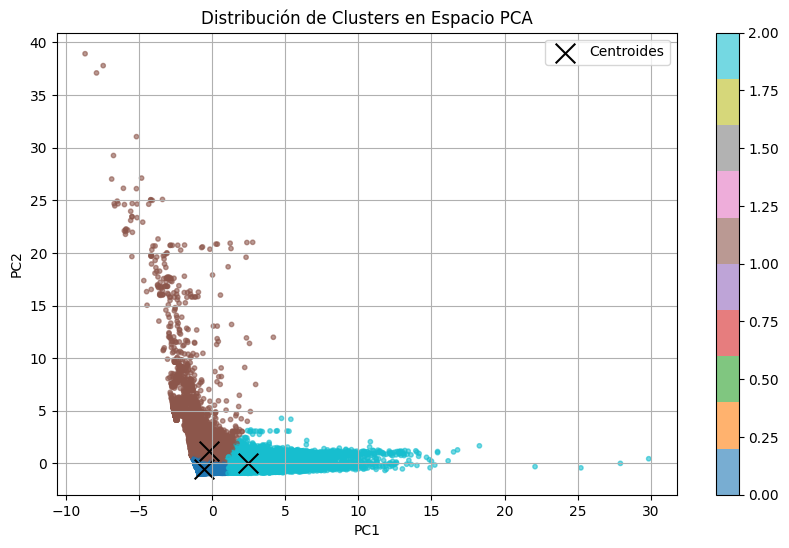

📊 Características destacadas por cluster (vs. media global):

Cluster 0:
   ↓ calculated_host_listings_count: -70.7%
   ↓ availability_365: -63.7%
   ↓ number_of_reviews: -61.1%

Cluster 1:
   ↑ calculated_host_listings_count: +212.5%
   ↑ availability_365: +137.7%
   ↑ minimum_nights: +115.2%

Cluster 2:
   ↑ number_of_reviews: +352.6%
   ↑ reviews_per_month: +281.0%
   ↓ calculated_host_listings_count: -65.1%


In [65]:
numeric_cols = [
    'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'calculated_host_listings_count', 'availability_365', 'price_USD'
]

results = {}

pca, scaler, X_pca, X_scaled = pca_analysis(df, numeric_cols)
key_features = extract_key_features(pca, numeric_cols)
best_k, sil_scores, inertias = find_optimal_clusters(X_pca[:, :2])
clusters, kmeans_model = clustering_analysis(X_pca[:, :2], best_k)
visualize_clusters_simple(X_pca[:, :2], clusters, kmeans_model)
analyze_cluster_characteristics(df, clusters, numeric_cols)

# Guardamos resultados
results.update({
    'pca': pca,
    'scaler': scaler,
    'clusters': clusters,
    'key_features': key_features,
    'best_k': best_k,
    'silhouette_scores': sil_scores
})

## **Análisis de los resultados**

### **Contexto**
El mercado de alojamientos de Airbnb presenta una gran heterogeneidad en términos de tipos de propiedades, estrategias de pricing, y patrones de uso. La segmentación de estos listings permite:

- Identificar diferentes modelos de negocio
- Comprender patrones de comportamiento de hosts
- Optimizar estrategias de marketing y pricing
- Detectar oportunidades de mercado
---

### **Objetivos Específicos**
- Reducir la dimensionalidad de las variables numéricas clave
- Identificar el número óptimo de clusters
- Caracterizar cada segmento identificado
- Proporcionar insights accionables para stakeholders
---

### **Variables Seleccionadas para el Análisis**

- `minimum_nights`: Número mínimo de noches requeridas
- `number_of_reviews`: Total de reseñas recibidas
- `reviews_per_month`: Promedio de reseñas por mes
- `calculated_host_listings_count`: Número de listings del host
- `availability_365`: Días disponibles en el año
- `price_USD`: Precio por noche en dólares
---

### **Preprocesamiento de los datos**
- Se aplica StandardScaler para normalizar todas las variables, necesario para PCA y clustering debido a diferentes escalas (precio vs. número de reseñas)
---

### **PCA: Análisis de componentes principales**
- Número de componentes: 5 (para análisis completo)
- Uso de los primeros 2 componentes para clustering (optimización computacional)

**Resultados:**

| Componente | Varianza Individual | Varianza Acumulada |
| ---------- | ------------------- | ------------------ |
| PC1        | 27.8%               | 27.8%              |
| PC2        | 18.8%               | 46.6%              |
| PC3        | 17.0%               | 63.6%              |
| PC4        | 15.4%               | 79.0%              |
| PC5        | 14.6%               | 93.6%              |

**PC1 - Dimensión de "Popularidad y Actividad" (27.8% varianza):**
- `reviews_per_month`: 0.680 (contribución principal)
- `number_of_reviews`: 0.680 (contribución principal)
- `availability_365`: 0.208 (contribución menor)

*Interpretación*: Este componente captura la actividad y popularidad del listing. Valores altos indican propiedades con alta rotación de huéspedes y feedback frecuente.

**PC2 - Dimensión de "Estrategia Comercial" (18.8% varianza):**

- `price_USD`: 0.571 (contribución principal)
- `availability_365`: 0.570 (contribución principal)
- `minimum_nights`: 0.456 (contribución moderada)

*Interpretación*: Representa la estrategia de pricing y disponibilidad. Valores altos sugieren propiedades con precios elevados, alta disponibilidad y requisitos de estancia mínima.


**Limitaciones Identificadas:**

- Los primeros dos componentes explican solo el 46.6% de la varianza total
- Existe información significativa en los componentes restantes
- Posible pérdida de información al usar solo PC1 y PC2 para clustering

**Patrones Identificados:**

- Separación clara entre listings orientados a volumen vs. premium
- Correlación entre actividad de reseñas y éxito del listing
- Estrategias diferenciadas de pricing y disponibilidad
---

### **Análisis de clustering**

#### **Cluster 0: "Hosts Casuales/Ocasionales" (61.0% del mercado)**

**Características Distintivas:**

- Listings por host: -70.7% vs. media global
- Disponibilidad anual: -63.7% vs. media global
- Número de reseñas: -61.1% vs. media global

**Perfil del Segmento:**

- **Tipo de Host:** Propietarios individuales, uso ocasional
- **Estrategia:** Alquiler esporádico, posiblemente para financiar vacaciones propias
- **Características:** Pocas propiedades, disponibilidad limitada, menor experiencia
- **Oportunidades:** Educación sobre optimización de listings, herramientas de gestión simplificadas

#### **Cluster 1: "Operadores Profesionales/Comerciales" (24.7% del mercado)**

**Características Distintivas:**

- Listings por host: +212.5% vs. media global
- Disponibilidad anual: +137.7% vs. media global
- Noches mínimas: +115.2% vs. media global

**Perfil del Segmento:**

- **Tipo de Host:** Gestores profesionales, empresas de property management
- **Estrategia:** Maximización de ingresos, gestión de múltiples propiedades
- **Características:** Portafolios extensos, alta disponibilidad, requisitos de estancia mínima
- **Oportunidades:** Herramientas de gestión avanzadas, optimización de pricing dinámico

#### **Cluster 2: "Hosts Exitosos/Establecidos" (14.3% del mercado)**

**Características Distintivas:**

- Número de reseñas: +352.6% vs. media global
- Reseñas por mes: +281.0% vs. media global
- Listings por host: -65.1% vs. media global

**Perfil del Segmento:**

- **Tipo de Host:** Propietarios experimentados, alta calidad de servicio
- **Estrategia:** Foco en calidad y experiencia del huésped
- **Características:** Pocas propiedades pero muy exitosas, alta rotación de huéspedes
- **Oportunidades:** Programas de hosts destacados, expansión controlada
---

### **Insights de Mercado**

**Concentración del Mercado:**

- El 61% del mercado está dominado por hosts casuales
- Solo el 14.3% representa hosts verdaderamente exitosos
- Existe una clara profesionalización del 24.7% del mercado

**Patrones de Comportamiento:**

- Los hosts profesionales priorizan volumen sobre calidad de servicio
- Los hosts exitosos mantienen portafolios pequeños pero altamente optimizados
- La mayoría de hosts opera de manera casual y subóptima
---

### **Conclusiones**:

El análisis de clustering de listings de Airbnb ha revelado tres segmentos claramente diferenciados que representan diferentes estrategias y niveles de madurez en el mercado de alojamientos de corta duración:

1. **Hosts Casuales (61%):** Representan la mayoría del mercado pero con menor optimización
2. **Operadores Profesionales (24.7%):** Enfocados en escala y volumen
3. **Hosts Exitosos (14.3%):** Optimizados para calidad y experiencia del huésped

Esta segmentación proporciona una base sólida para estrategias differentiated de producto, marketing y soporte, permitiendo a Airbnb y otros stakeholders del ecosistema desarrollar enfoques específicos para cada segmento.

Los resultados demuestran la efectividad de combinar PCA con clustering para identificar patrones en datasets grandes y complejos, aunque se identifican oportunidades significativas para mejorar tanto la metodología como la profundidad del análisis.
